# Train Binary Segmentation
## Instructions to run
- Run the first section (Environment setup) to install the packages
- Edit the configuration variables in the [Constants](#constants) section and the [Training configuration](#training-configuration) section as needed.
- Customize the image transformations pipeline in the [Image transformations and augmentation](#image-transformations-and-augmentation) section as needed.
- Run all the cells
- *Note*: It is recommended to run this notebook on an HPC cluster, on a computer with an NVIDIA (CUDA-capable) GPU.

## Import packages

In [19]:
from pathlib import Path
import math
import os
import requests
from zipfile import ZipFile

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
if not hasattr(Image, 'Resampling'):
    Image.Resampling = Image

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow.keras.backend as K
from tensorflow.config import list_physical_devices
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import optimizers
from tensorflow.keras.utils import custom_object_scope

from fl_tissue_model_tools.transforms import get_elastic_dual_transform
from fl_tissue_model_tools.preprocessing import get_batch_augmentor
from fl_tissue_model_tools import models, models_util, defs
from fl_tissue_model_tools.helper import get_img_mask_paths

# Make sure TensorFlow is using GPU - print out the available GPUs
available_gpus = list_physical_devices('GPU')
if len(available_gpus) == 0:
    print("WARNING: TensorFlow isn't using a GPU.")
else:
    print(f"Available GPUS:\n{available_gpus}")

Available GPUS:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<a name="constants"></a>
## Constants

In [22]:
rand_seed = 1234

batch_size = 8

# size of the random crop window, cannot be larger than the image size
crop_window = (512, 512)

# model input shape. cropped images/masks are resampled to this shape
# target_shape must be divisible by 32, and must be square if using the patch-blending segmentor
target_shape = (320, 320)
#target_shape = crop_window     # uncomment to disable resizing the crops

training_dir = defs.MODEL_TRAINING_DIR / "binary_segmentation"
experiment_number = models_util.get_last_exp_num() + 1
checkpoint_save_path = training_dir / "checkpoints" / f"checkpoint_{experiment_number}.h5"
log_dir = training_dir / f"logs_{experiment_number}"

images_dir = os.path.join(training_dir, "images")
labels_dir = os.path.join(training_dir, "masks")

# number of times to iterate over the samples each epoch
repeat_dset_n_times = 50

In [23]:
# Create the training and directory if it doesn't exist
Path(training_dir).mkdir(exist_ok=True)
Path(log_dir).mkdir(exist_ok=True)

### Hyperparameter search space

In [24]:
filter_counts_options = [
    (16, 32, 64, 128),
    (32, 64, 128, 256),
    (64, 128, 256, 512)
]

# Scale learning rate options linearly according to batch size (stays as-is when batch size is 16)
hp_search_initial_lr_options = [1e-4, 2.5e-4, 5e-4, 1e-3, 2.5e-3, 5e-3, 1e-2]
hp_search_initial_lr_options = np.array(hp_search_initial_lr_options) * batch_size/16

## Download demo training dataset

In [5]:
filename = "branching_training_data.zip"
url = f"https://github.com/fogg-lab/tissue-model-analysis-tools/raw/main/sample_data/{filename}"
data = requests.get(url).content
archive_save_path = os.path.join(training_dir, filename)
open(archive_save_path, 'wb').write(data)

# Extract the archive
with ZipFile(archive_save_path, 'r') as data_archive:
    data_archive.extractall(training_dir)

# Delete the archive
os.remove(archive_save_path)

## Validate data paths

In [6]:
image_mask_paths = get_img_mask_paths(images_dir, labels_dir)
img_paths, mask_paths = zip(*image_mask_paths)

print(f"Found {len(image_mask_paths)} image/label pairs")

for img_path, mask_path in image_mask_paths:
    image = cv2.imread(img_path, 0)
    mask = cv2.imread(mask_path, 0)

    assert image.shape == mask.shape, (
        f"Image {img_path} and mask {mask_path} have different shapes: {image.shape} vs {mask.shape}"
    )

    if np.unique(mask).tolist() not in ([0], [255], [0, 255]):
        print(f"Mask {mask_path} has unexpected values: {np.unique(mask)}")

Found 42 image/label pairs


## Data pipeline

### Get training and validation image paths

In [7]:
n_val = int(len(img_paths) * 0.2)

# Shuffle the data image/mask keeping pairs together

#indices = np.random.permutation(len(img_paths))    # non-seeded random shuffle
rs = np.random.RandomState(seed=rand_seed)
indices = rs.permutation(len(img_paths))

img_paths = [img_paths[i] for i in indices]
mask_paths = [mask_paths[i] for i in indices]

train_img_paths = img_paths[: -n_val]
train_mask_paths = mask_paths[:-n_val]

val_img_paths = img_paths[-n_val:]
val_mask_paths = mask_paths[-n_val:]

## Compute sample weights & mean/std for training data

In [8]:
y_train_labels = models_util.load_y(train_mask_paths)

n_fg = np.sum(y_train_labels == 1)
n_bg = np.sum(y_train_labels == 0)
fg_weight = float(n_fg + n_bg) / (2.0 * n_fg)
bg_weight = float(n_fg + n_bg) / (2.0 * n_bg)
sample_weights = {0: bg_weight, 1: fg_weight}
sample_weights

{0: 0.5218229092992872, 1: 11.955851122845736}

In [9]:
# Get the mean and std of the training set images
x_train_imgs = models_util.load_x(img_paths)
im_mean = np.mean(x_train_imgs)
im_std = np.std(x_train_imgs)

im_mean, im_std

(20396.227041382925, 16156.001084382677)

<a name="image-transformations-augmentation"></a>
### Image transformations and augmentation

In [10]:
# Helper functions

def get_resizer(ds_shape):
    def ds_im_mask(image, mask):
        """Downscale image with Lanczos interpolation and mask with nearest neighbor"""
        image = cv2.resize(image, ds_shape, interpolation=cv2.INTER_LANCZOS4)
        mask = np.array(Image.fromarray(mask).resize(ds_shape, resample=Image.Resampling.NEAREST))
        return {'image': image, 'mask': mask}
    return ds_im_mask

def get_normalizer(mean, std):
    def norm_im(image, mask):
        """Normalize image with mean and std of training set images"""
        image = ((image - mean) / std).astype(np.float32)
        return {'image': image, 'mask': mask}
    return norm_im

In [11]:
train_transforms = train_transforms = [
    A.Compose([
        A.Rotate(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
        A.RandomCrop(height=crop_window[0], width=crop_window[1]),
        A.Flip(p=0.5),
        A.RandomBrightnessContrast(p=0.7),
        A.OneOf([
                A.MultiplicativeNoise(p=0.5, elementwise=True),
                A.AdvancedBlur(p=0.5)
        ], p=0.8),
    ]),     # Albumentations pipeline
    get_elastic_dual_transform(p=0.85),
    get_resizer(target_shape),
    get_normalizer(im_mean, im_std)
]

val_transforms = [
    A.Compose([
        A.RandomCrop(height=crop_window[0], width=crop_window[1]),
        A.Flip(p=0.5),
        A.RandomRotate90(p=0.5)
    ]),
    get_resizer(target_shape),
    get_normalizer(im_mean, im_std)
]

train_augmentor = get_batch_augmentor(train_transforms)
val_augmentor = get_batch_augmentor(val_transforms)

### Create the training and validation data generators

In [12]:
rs = np.random.RandomState(seed=rand_seed)

train_gen = models_util.BinaryMaskSequence(
    batch_size, train_img_paths, train_mask_paths, rs,
    models_util.load_x, models_util.load_y, augmentation_function=train_augmentor,
    sample_weights=sample_weights, repeat_n_times=repeat_dset_n_times, shuffle=True
)

val_gen = models_util.BinaryMaskSequence(
    batch_size, val_img_paths, val_mask_paths,
    rs, models_util.load_x, models_util.load_y, augmentation_function=val_augmentor,
    sample_weights=sample_weights, repeat_n_times=repeat_dset_n_times, shuffle=True)

### Test the training generator

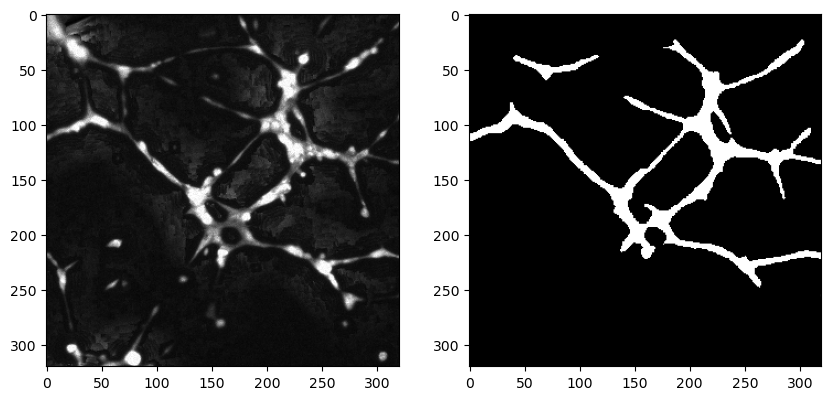

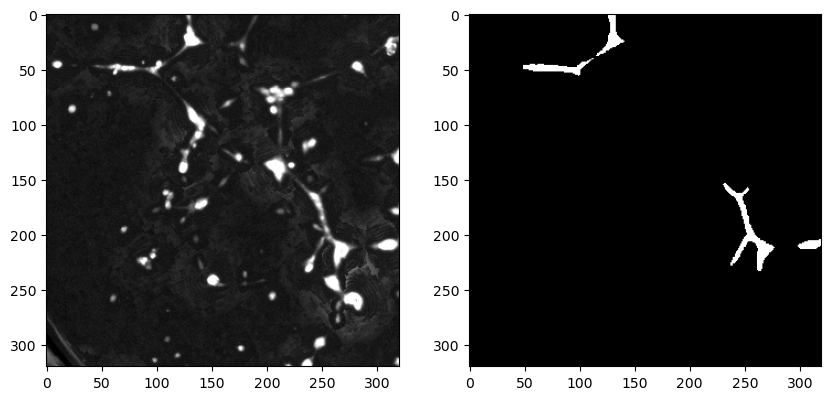

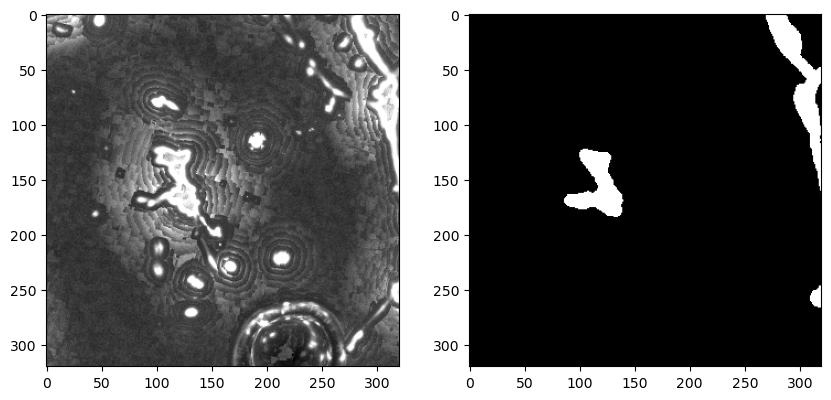

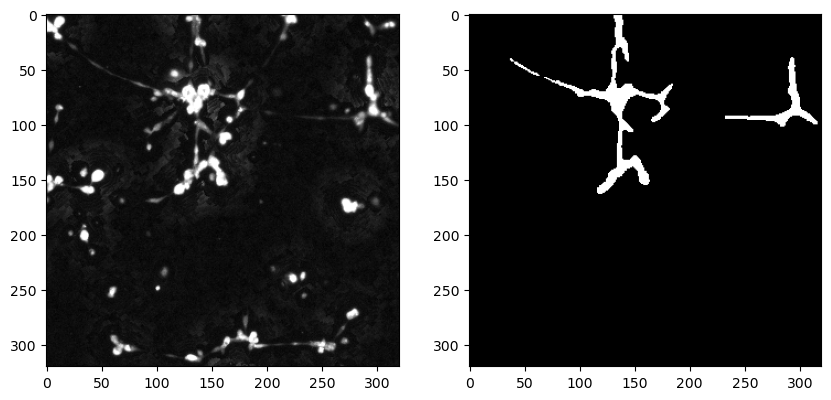

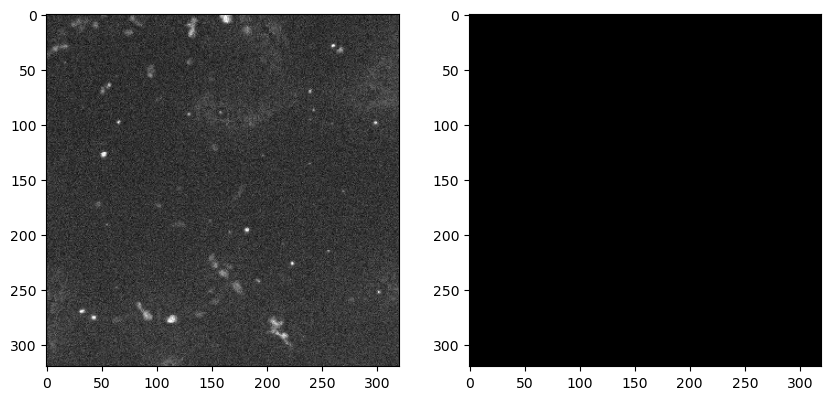

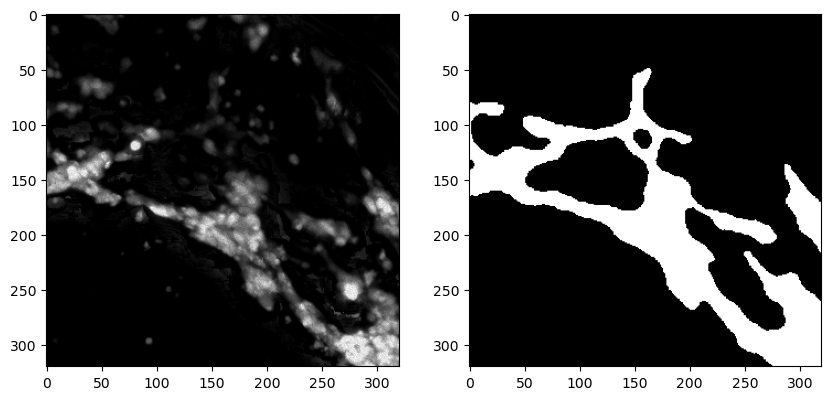

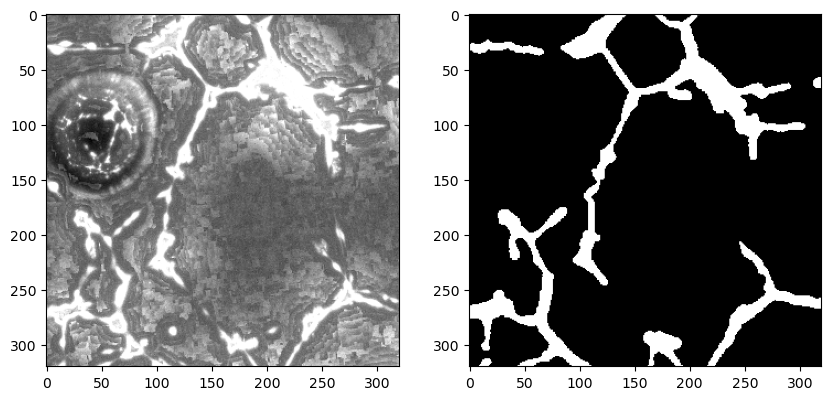

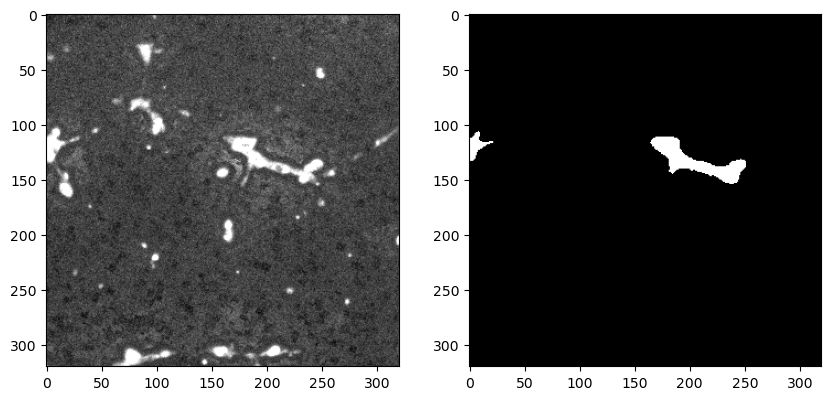

In [13]:
X, y, _ = train_gen[1]
for i in range(batch_size):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X[i][:,:,0], cmap='gray')
    ax[1].imshow(y[i][:,:,0], cmap='gray')
    plt.show()

### Test the validation generator

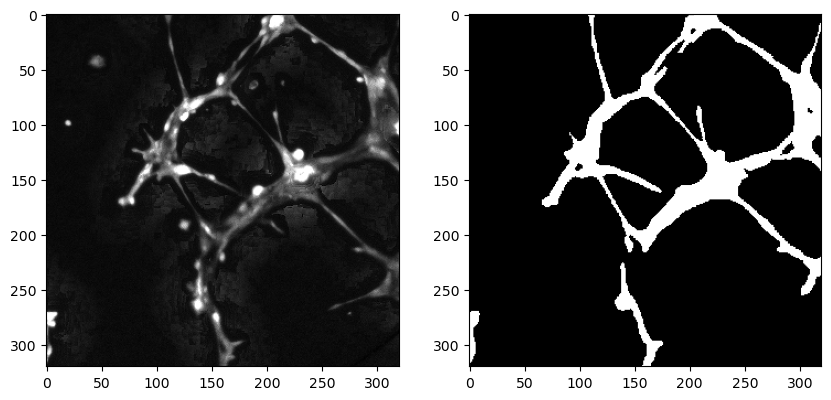

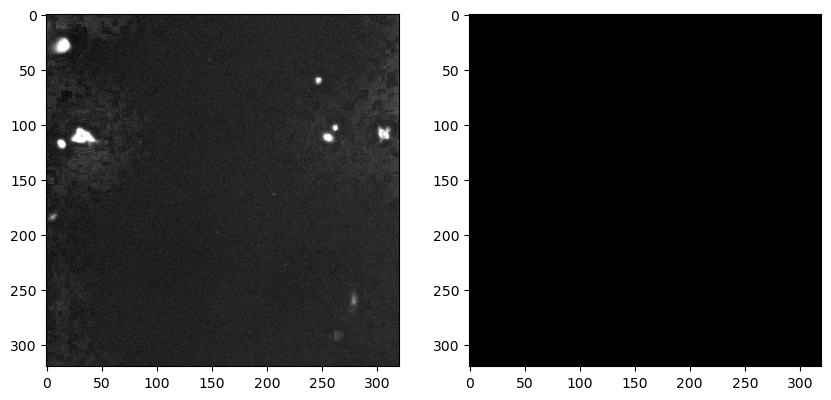

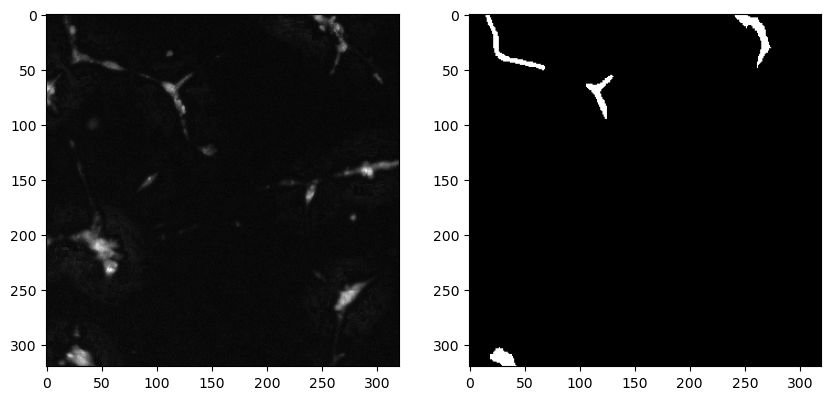

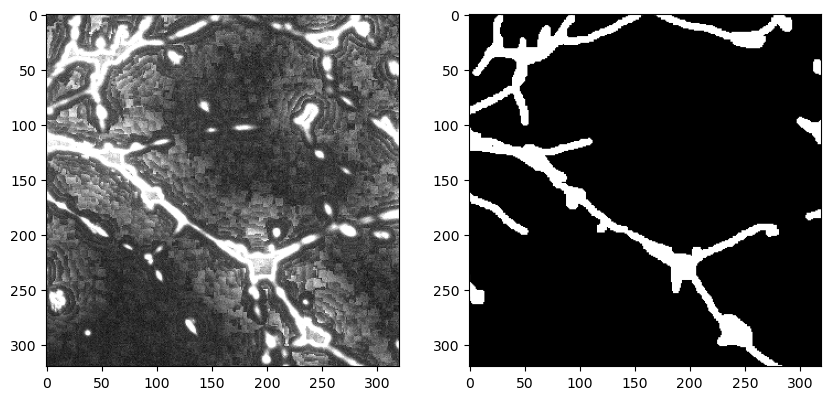

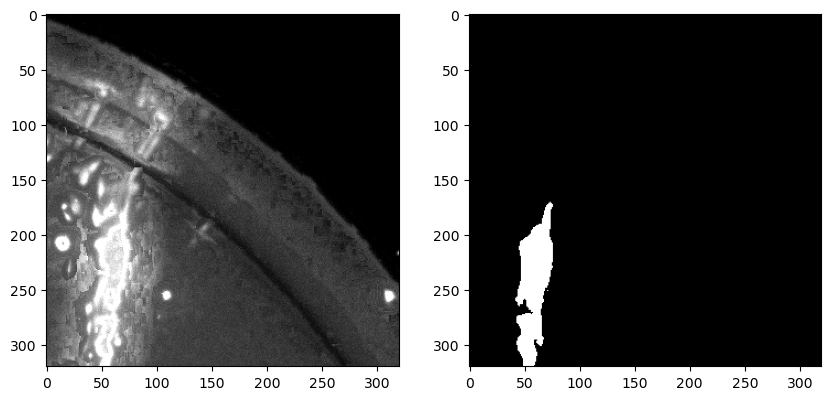

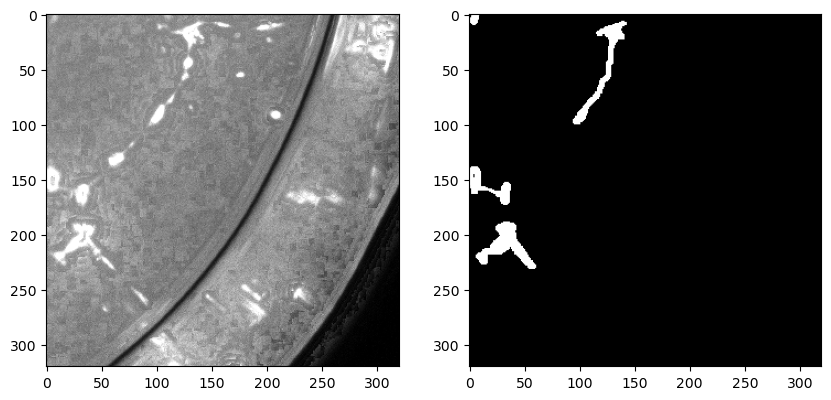

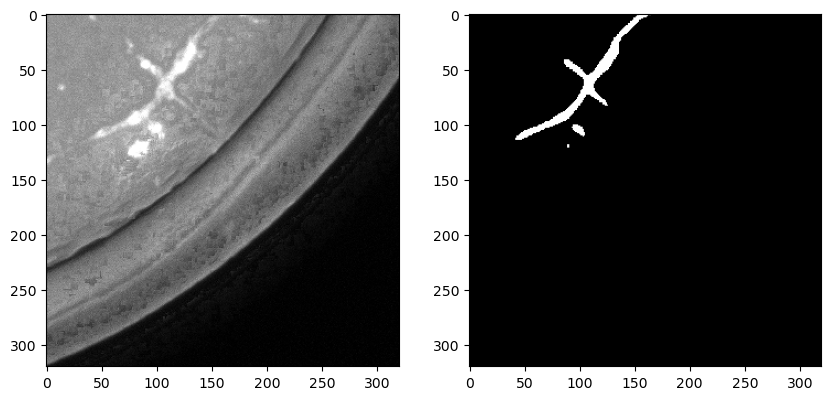

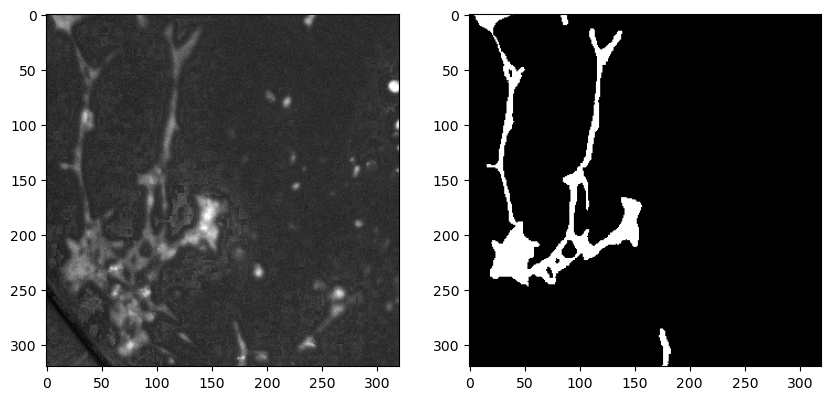

In [14]:
X, y, _ = val_gen[1]
for i in range(batch_size):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X[i][:,:,0], cmap='gray')
    ax[1].imshow(y[i][:,:,0], cmap='gray')
    plt.show()

<a name="training-configuration"></a>
## Training configuration

*We'll warm up to the initial learning rate and either use a cyclic schedule or reduce it when val_loss plateaus.*

Parameters you should customize:
- `n_epochs`
- `hp_search_epochs`
- `weight_decay`

Extra parameters you should customize for cyclic schedule:
- `cyclic_lr_mult`
- `num_cycles`

Extra parameters you should customize for reduce lr on plateau:
- `lr_patience`
- `lr_reduction_factor`

In [15]:
n_epochs = 50
hp_search_epochs = n_epochs // 5

epoch_len = math.ceil(((len(train_img_paths)) * train_gen.repeat_n_times) / batch_size)
linear_warmup_steps = epoch_len

# use_cosine_decay_restarts: true to use a cyclic lr schedule, false for ReduceLROnPlateau
use_cosine_decay_restarts = True

# get optimizer options for grid search (vary the initial learning rate)
hp_search_optimizer_options = []
for initial_lr in hp_search_initial_lr_options:
    if use_cosine_decay_restarts:
        # cosine annealing parameters - timed so the last cycle ends at the end of training
        cycle_lr_mult = 0.5         # decrease initial lr at the end of each cycle (m_mul)
        num_cycles = 3              # number of full cycles

        # figure out what the first_decay_steps should be
        # start counting after the warmup steps
        total_steps = epoch_len * n_epochs - linear_warmup_steps

        # round up and add 1 to prevent an extra restart at the end
        first_decay_steps = math.ceil(total_steps / (2**num_cycles - 1)) + 1

        learning_rate = optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=initial_lr,
            first_decay_steps=first_decay_steps,
            t_mul=2.0,  # our first_decay_steps calculation assumes t_mul=2
            m_mul=cycle_lr_mult
        )
        learning_rate = optimizers.serialize(learning_rate)
    else:
        # patience: number of epochs with no improvement after which learning rate will be reduced
        patience = 4
        lr_reduction_factor = 0.5
        learning_rate = initial_lr
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=lr_reduction_factor,
            patience=patience,
            verbose=1,
            mode='min'
        )

    lr_schedule = models_util.WarmupSchedule(warmup_steps=linear_warmup_steps,
                                             after_warmup_lr=learning_rate)

    weight_decay = 1e-4     # weight decay for AdamW

    optimizer = optimizers.experimental.AdamW(learning_rate=lr_schedule, weight_decay=weight_decay)
    optimizer_config = optimizers.serialize(optimizer)

    hp_search_optimizer_options.append(optimizer_config)

## Hyperparameter search

In [16]:
metrics=[models_util.mean_iou_coef_factory(thresh=0.5)]
loss = BinaryCrossentropy()

callbacks = []

# csv logger - clear previous log if it exists

if os.path.exists(f"{training_dir}/hp_search_log.csv"):
    os.remove(f"{training_dir}/hp_search_log.csv")
csv_logger = CSVLogger(f"{training_dir}/hp_search_log.csv", append=True)

callbacks.append(csv_logger)

# reduce lr on plateau
if not use_cosine_decay_restarts:
    callbacks.append(reduce_lr)

gs = models.UNetXceptionGridSearch(
    save_dir=f"{training_dir}/hp_search",
    filter_counts_options=filter_counts_options,
    n_outputs=1,
    img_shape=target_shape,
    optimizer_cfg_options=hp_search_optimizer_options,
    loss=loss,
    output_act="sigmoid",
    metrics=metrics,
    callbacks=callbacks
)

with custom_object_scope({'WarmupSchedule': models_util.WarmupSchedule}):
    gs.search(
        "val_mean_iou_coef",
        "max",
        train_gen,
        steps_per_epoch=len(train_gen),
        search_verbose=True,
        validation_data=val_gen,
        validation_steps=len(val_gen),
        epochs=hp_search_epochs,
        use_multiprocessing=True, workers=4
    )

Testing filter counts: (16, 32, 64, 128)
Optimizer index: 0
Epoch 1/10
212/212 [==============================] - 52s 167ms/step - loss: 0.8900 - mean_iou_coef: 0.1027 - val_loss: 3.4714 - val_mean_iou_coef: 0.0562
Epoch 2/10
212/212 [==============================] - 36s 166ms/step - loss: 0.4578 - mean_iou_coef: 0.1550 - val_loss: 2.7289 - val_mean_iou_coef: 0.0257
Epoch 3/10
212/212 [==============================] - 36s 168ms/step - loss: 0.3717 - mean_iou_coef: 0.1758 - val_loss: 0.5284 - val_mean_iou_coef: 0.1885
Epoch 4/10
212/212 [==============================] - 36s 168ms/step - loss: 0.3389 - mean_iou_coef: 0.1782 - val_loss: 0.3688 - val_mean_iou_coef: 0.1742
Epoch 5/10
212/212 [==============================] - 37s 169ms/step - loss: 0.3247 - mean_iou_coef: 0.1904 - val_loss: 0.3356 - val_mean_iou_coef: 0.1705
Epoch 6/10
212/212 [==============================] - 37s 168ms/step - loss: 0.3085 - mean_iou_coef: 0.1913 - val_loss: 0.3318 - val_mean_iou_coef: 0.1780
Epoch 7/10

In [25]:
# Get the best learning rate schedule
with custom_object_scope({'WarmupSchedule': models_util.WarmupSchedule}):
    best_lr_schedule = gs.best_optimizer_cfg['config']['learning_rate']

In [26]:
# Show the best hyperparameters
print("Best filter counts: ", gs.best_filter_counts)
print("Best optimizer: ", gs.best_optimizer_cfg)
print("Best initial learning rate: ", round(float(best_lr_schedule(linear_warmup_steps)), 6))
print("Best score: ", gs.best_score)
print("Best score index: ", gs.best_score_idx)

Best filter counts:  (32, 64, 128, 256)
Best optimizer:  {'class_name': 'Custom>AdamW', 'config': {'name': 'AdamW', 'weight_decay': 0.0001, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': <fl_tissue_model_tools.models_util.WarmupSchedule object at 0x7fd020459910>, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}}
Best initial learning rate:  0.00125
Best score:  0.3815930187702179
Best score index:  11


## Train the model

In [27]:
K.clear_session()

with custom_object_scope({'WarmupSchedule': models_util.WarmupSchedule}):
    optimizer = optimizers.deserialize(gs.best_optimizer_cfg)

model = models.build_UNetXception(1, target_shape, filter_counts=gs.best_filter_counts,
                                  output_act="sigmoid")

metrics=[models_util.mean_iou_coef_factory(thresh=0.5)]

model.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=metrics)

callbacks = [
    ModelCheckpoint(checkpoint_save_path, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1),
    CSVLogger(f"{log_dir}/training_log.csv")
]

callbacks = callbacks if use_cosine_decay_restarts else callbacks + [reduce_lr]

h = model.fit(train_gen, validation_data=val_gen, epochs=n_epochs, callbacks=callbacks)

Epoch 1/50
212/212 [==============================] - 77s 323ms/step - loss: 0.5109 - mean_iou_coef: 0.1805 - val_loss: 2.5748 - val_mean_iou_coef: 0.2487
Epoch 2/50
212/212 [==============================] - 68s 321ms/step - loss: 0.2673 - mean_iou_coef: 0.2346 - val_loss: 2.4074 - val_mean_iou_coef: 0.2568
Epoch 3/50
212/212 [==============================] - 69s 325ms/step - loss: 0.2077 - mean_iou_coef: 0.2573 - val_loss: 0.3335 - val_mean_iou_coef: 0.3196
Epoch 4/50
212/212 [==============================] - 69s 323ms/step - loss: 0.1929 - mean_iou_coef: 0.2650 - val_loss: 0.1786 - val_mean_iou_coef: 0.2783
Epoch 5/50
212/212 [==============================] - 69s 325ms/step - loss: 0.1611 - mean_iou_coef: 0.2895 - val_loss: 0.1436 - val_mean_iou_coef: 0.2751
Epoch 6/50
212/212 [==============================] - 68s 319ms/step - loss: 0.1580 - mean_iou_coef: 0.3026 - val_loss: 0.1385 - val_mean_iou_coef: 0.3053
Epoch 7/50
212/212 [==============================] - 68s 323ms/step -

## Test the model

In [28]:
val_batch_num = 0
val_x, val_y, _ = val_gen[val_batch_num]
preds = model.predict(val_x)

1/1 [==============================] - 0s 301ms/step


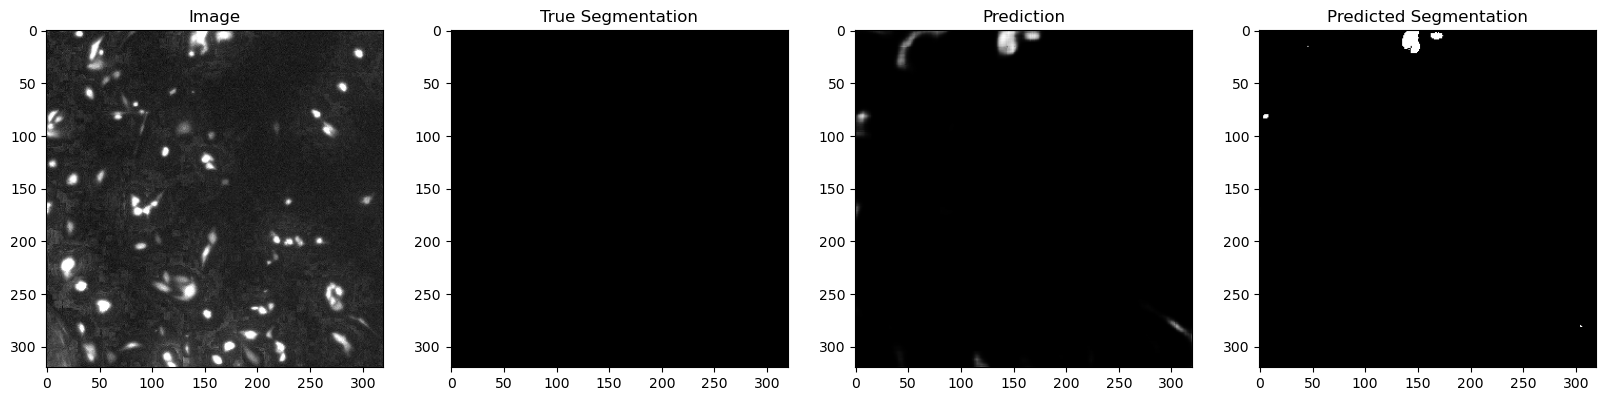

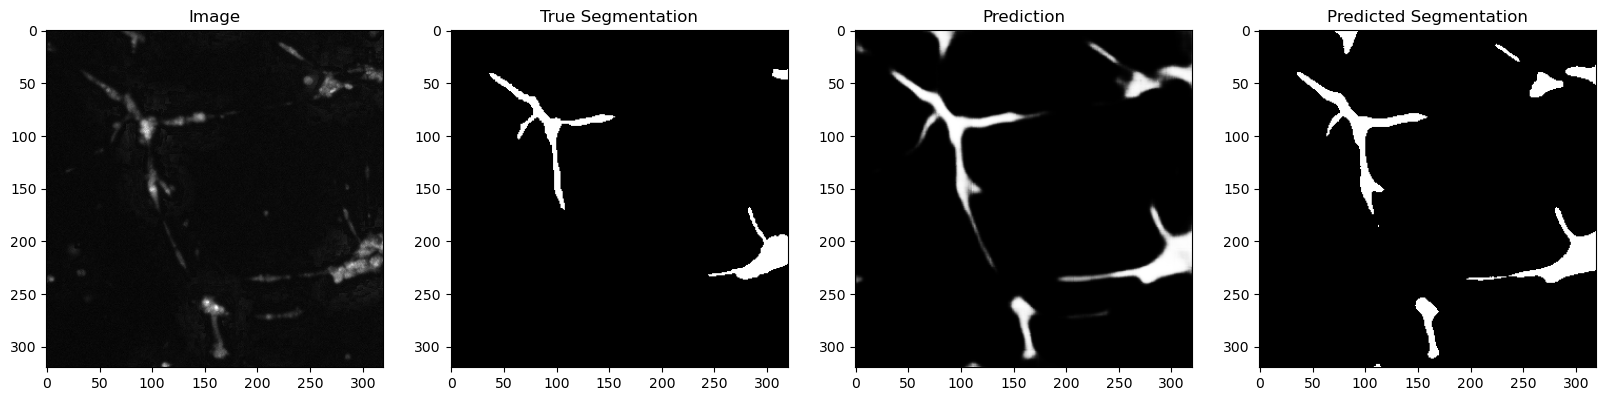

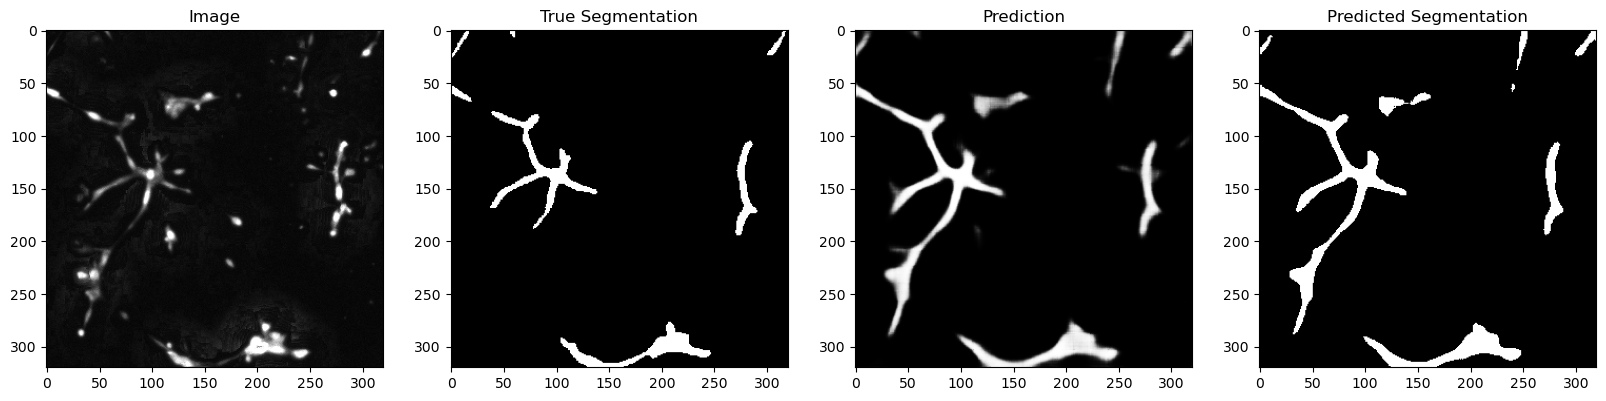

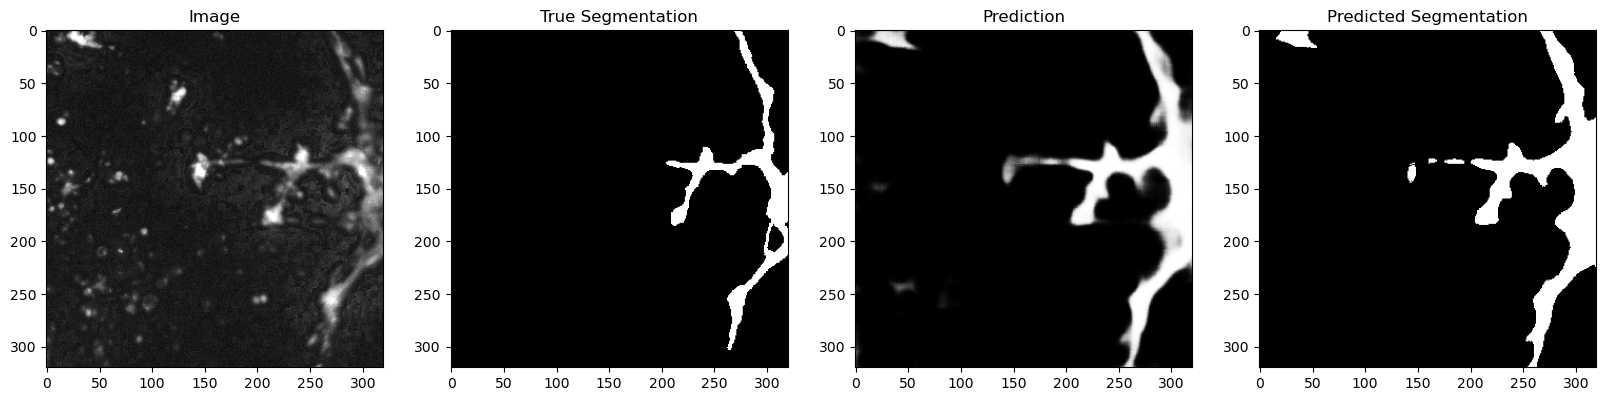

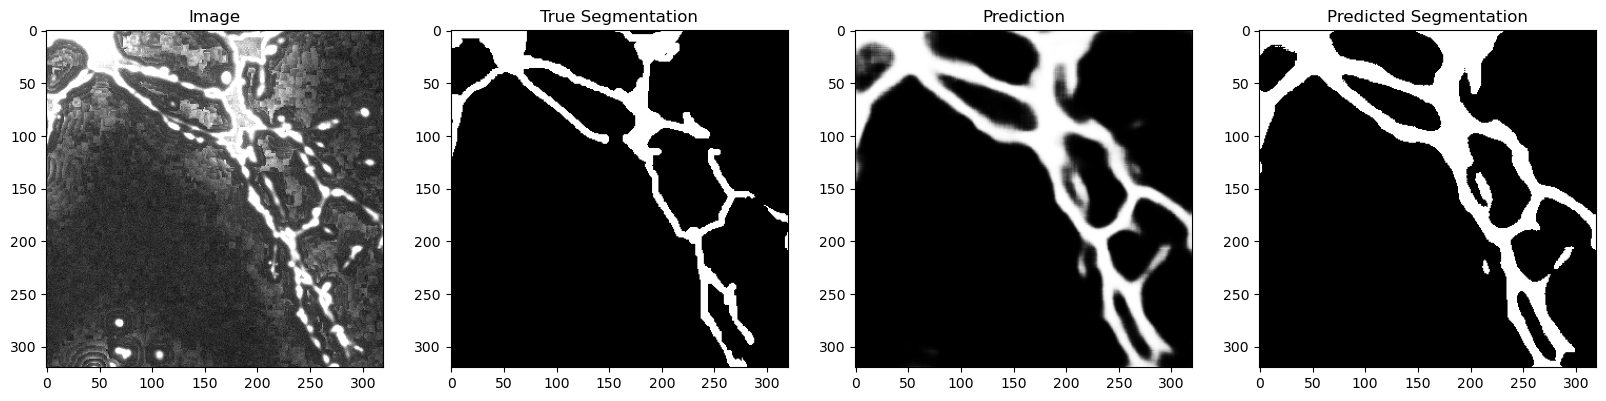

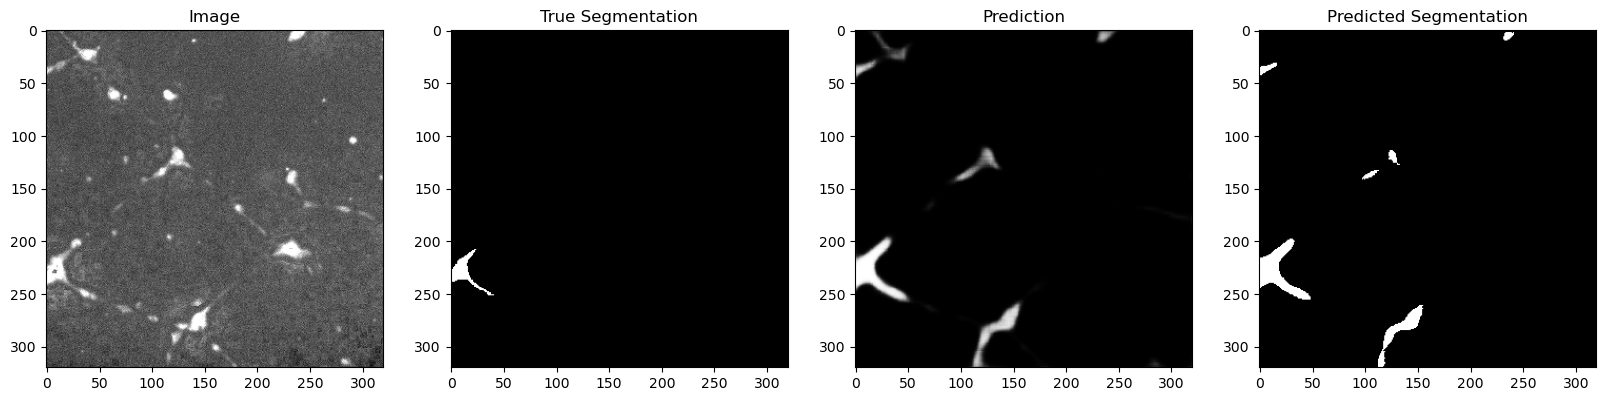

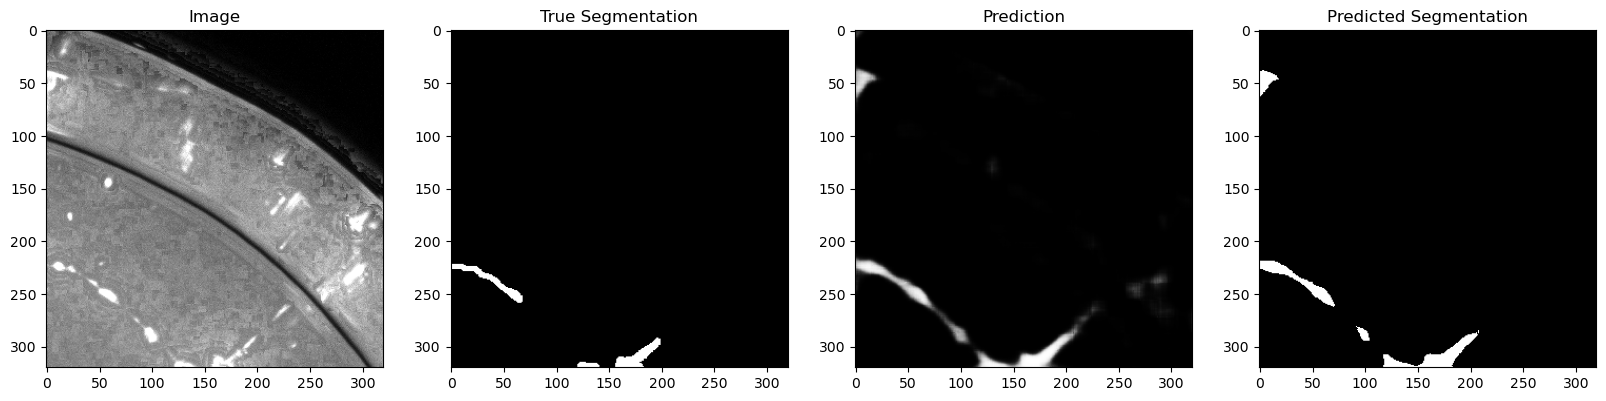

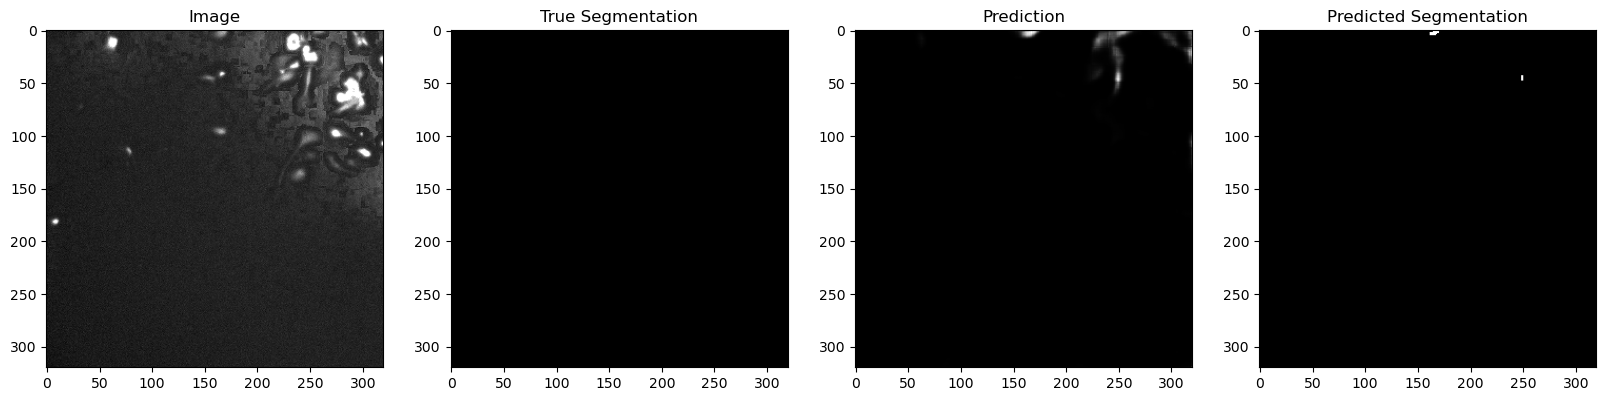

In [29]:
for sample_idx in range(0, batch_size):
    image = val_x[sample_idx]
    ground_truth = val_y[sample_idx]
    prediction = preds[sample_idx]
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].imshow(image[:,:,0], cmap='gray')
    ax[0].set_title("Image")
    ax[1].imshow(ground_truth[:,:,0], cmap='gray')
    ax[1].set_title("True Segmentation")
    ax[2].imshow(prediction[:,:,0], cmap='gray')
    ax[2].set_title("Prediction")
    ax[3].imshow(np.greater(prediction, 0.5)[:,:,0], cmap='gray')
    ax[3].set_title("Predicted Segmentation")
    plt.show()

## Save configuration for patch-blending segmentor

In [30]:
# Create patch segmentor config and save it
cfg = {
    "patch_size": crop_window[0],
    "checkpoint_file": checkpoint_save_path.name,
    "filter_counts": gs.best_filter_counts,
    "ds_ratio": target_shape[0] / crop_window[0],
    "norm_mean": im_mean,
    "norm_std": im_std,
    "channels": 1
}
models_util.save_unet_patch_segmentor_cfg(cfg)